In [193]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import acf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf 
from statsmodels.tsa.arima.model import ARIMA
import scipy.stats as stats
from scipy.stats import skew, kurtosis
from arch import arch_model
from IPython.display import display

In [3]:
#import dataset
dfpath = '/Users/markoshea/Desktop/Working Directories/Datasets/qqq.csv'
qqqdf = pd.read_csv(dfpath) 

In [4]:
#view data
print(qqqdf)

            date TICKER        PRC
0       1/3/2000    QQQ  189.50000
1       1/4/2000    QQQ  176.01563
2       1/5/2000    QQQ  172.37500
3       1/6/2000    QQQ  161.50000
4       1/7/2000    QQQ  177.00000
...          ...    ...        ...
6284  12/24/2024    QQQ  529.96002
6285  12/26/2024    QQQ  529.59998
6286  12/27/2024    QQQ  522.56000
6287  12/30/2024    QQQ  515.60999
6288  12/31/2024    QQQ  511.23001

[6289 rows x 3 columns]


IMPORTANT!!!! THERE IS AN OUTLIER IN THIS DATASET!! MUST REMOVE TO PROCEED

In [37]:
qqqdf['log_ret'] = np.log(qqqdf['PRC'] / qqqdf['PRC'].shift(1))
qqqdf.dropna(inplace=True)

In [38]:
#skewness
qqqdf['PRC'].skew()

1.4026407679468273

In [39]:
#kurtosis
kurt1 = kurtosis(qqqdf['PRC'], fisher=True, nan_policy='omit') 
kurt2 = kurtosis(qqqdf['PRC'], fisher=False, nan_policy='omit') 

print(f"Kurtosis relative to normal distribution: {kurt1}")
print(f"Raw kurtosis: {kurt2}")

Kurtosis relative to normal distribution: 0.9239889552913931
Raw kurtosis: 3.923988955291393


In [40]:
#skewness for log return
qqqdf['log_ret'].skew()

-8.507622344491814

In [41]:
#kurtosis for log return
kurt1 = kurtosis(qqqdf['log_ret'], fisher=True, nan_policy='omit') 
kurt2 = kurtosis(qqqdf['log_ret'], fisher=False, nan_policy='omit') 

print(f"Kurtosis relative to normal distribution: {kurt1}")
print(f"Raw kurtosis: {kurt2}")

Kurtosis relative to normal distribution: 323.88354476443715
Raw kurtosis: 326.88354476443715


In [ ]:
#squared log returns 
qqqdf['sq_ret'] = qqqdf['log_ret'] ** 2

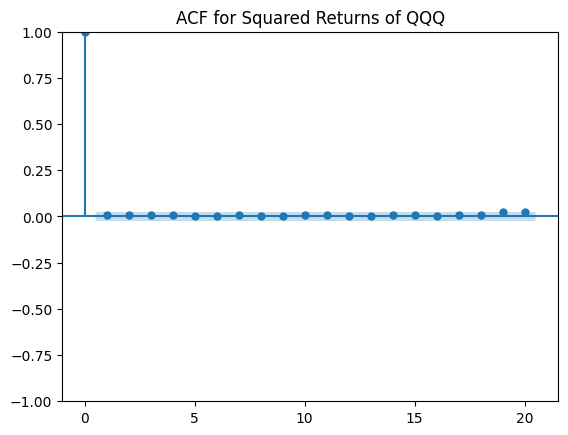

In [152]:
# Plot autocorrelation function (ACF) up to lag 20
plot_acf(qqqdf['sq_ret'], lags=20)
plt.title("ACF for Squared Returns of QQQ")
plt.show()

# Compute and print ACF values in a table
acf_values = acf(qqqdf['sq_ret'], nlags=20)

In [27]:
acf_table = pd.DataFrame({"Lag": range(21), "Autocorrelation": acf_values})
display(acf_table)

,Lag,Autocorrelation
0,0,1.000000
1,1,0.006885
2,2,0.009717
3,3,0.006239
4,4,0.005785
5,5,0.004543
6,6,0.004177
7,7,0.006711
8,8,0.004822
9,9,0.003740


Q2 (a)

We see that for the continuously compounded returns, the skewness is -8.48, a strong negative skew, which suggests large downward movements in price are more common than upward movements. We find the excess kurtosis is 322.34 and raw kurtosis is 325.34, suggesting more outliers than a normal distribution and fat tails. We find that the autocorrelation function shows no persistent autocorrelation, which means shocks are quickly absorbed and hence low volatility clustering.

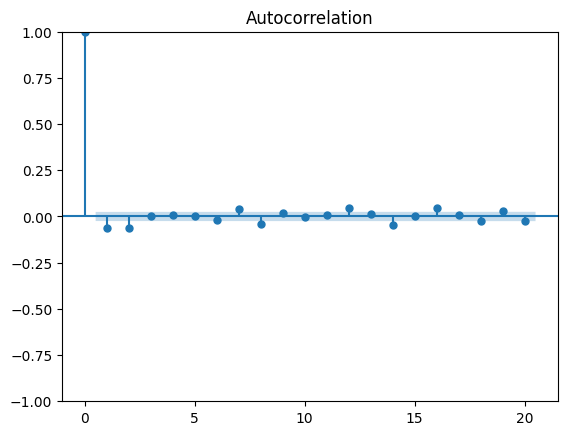

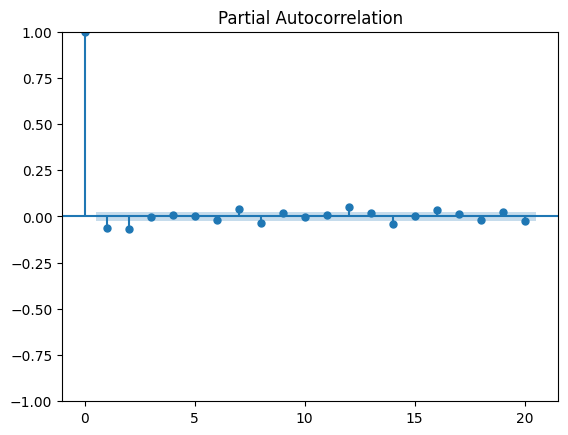

In [165]:
#fit ARMA for the mean
##plot ACF and PACF to pick p and q
plot_acf(qqqdf['log_ret'].dropna(), lags=20)
plot_pacf(qqqdf['log_ret'].dropna(), lags=20)
plt.show()

One doesn't seem more promising than the other - fit ARMA(1,1) and examine residuals -> some dependence was left after i did. Fit an ARMA(2,1) instead

In [166]:
#fit ARMA(2,1) for the mean
arma_model = ARIMA(qqqdf['log_ret'].dropna(), order=(2,0,1)).fit()
print(arma_model.summary())

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                log_ret   No. Observations:                 6286
Model:                 ARIMA(2, 0, 1)   Log Likelihood               15932.957
Date:                Fri, 07 Feb 2025   AIC                         -31855.915
Time:                        19:44:54   BIC                         -31822.184
Sample:                             0   HQIC                        -31844.229
                               - 6286                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0002      0.000      0.667      0.505      -0.000       0.001
ar.L1         -0.0088      0.136     -0.065      0.948      -0.274       0.257
ar.L2         -0.0616      0.012     -5.258      0.0

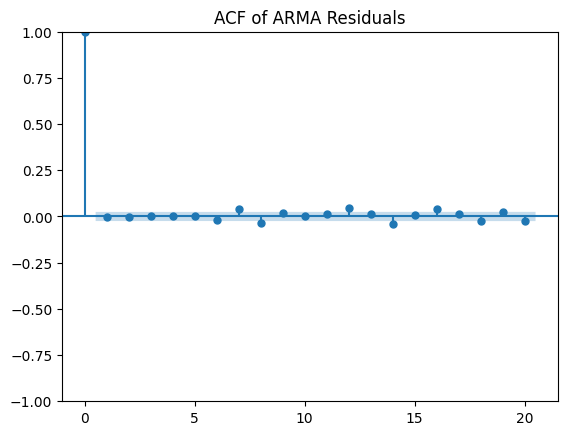

In [167]:
#ACF of ARMA residuals for mean
residuals = arma_model.resid
plot_acf(residuals, lags=20)
plt.title("ACF of ARMA Residuals")
plt.show()

In [203]:
#fit GARCH (1,1) to the ARMA residuals
qqqdf['arma_resid'] = arma_model.resid

garch_model = arch_model(qqqdf['arma_resid'].dropna(), vol='Garch', p=1, q=1, mean='Zero', dist='normal')

# Fit the model
garch_results = garch_model.fit(disp='off')
print(garch_results.summary())

                       Zero Mean - GARCH Model Results                        
Dep. Variable:             arma_resid   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:                18056.8
Distribution:                  Normal   AIC:                          -36107.5
Method:            Maximum Likelihood   BIC:                          -36087.3
                                        No. Observations:                 6286
Date:                Fri, Feb 07 2025   Df Residuals:                     6286
Time:                        20:42:46   Df Model:                            0
                              Volatility Model                              
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
omega      5.3667e-06  3.009e-09   1783.571      0.000 [5.

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/arch/univariate/base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0003681. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


In [204]:
print(garch_results.params)

omega       0.000005
alpha[1]    0.146359
beta[1]     0.839620
Name: params, dtype: float64


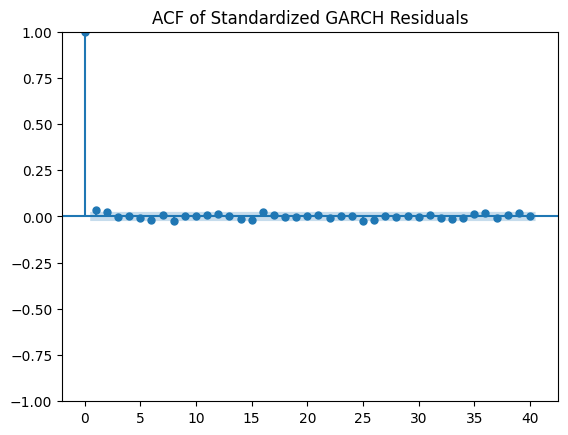

In [ ]:
#plot ACF for standardized residuals from garch
std_resid = garch_results.std_resid  

plot_acf(std_resid, lags=40)
plt.title("ACF of Standardized GARCH Residuals")
plt.show()

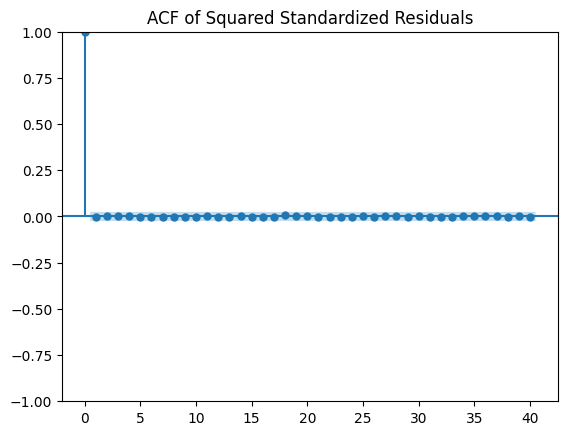

In [230]:
plot_acf(std_resid ** 2, lags=40)
plt.title("ACF of Squared Standardized Residuals")
plt.show()

Q2 (b) Doesn't seem to be any significant autocorrelation in these, so GARCH (1,1) seems to be a good fit

In [210]:
forecast_horizon = np.arange(19, 252) #19 and 252 trading days in a month, year respectively

garch_forecast = garch_results.forecast(start=len(qqqdf) - 1, horizon=252)

forecast_vol = np.sqrt(garch_forecast.variance.values[-1, 19:252])
print(garch_forecast.variance.iloc[-1]) 

h.001    0.000179
h.002    0.000182
h.003    0.000184
h.004    0.000187
h.005    0.000190
           ...   
h.248    0.000377
h.249    0.000377
h.250    0.000377
h.251    0.000377
h.252    0.000377
Name: 6288, Length: 252, dtype: float64


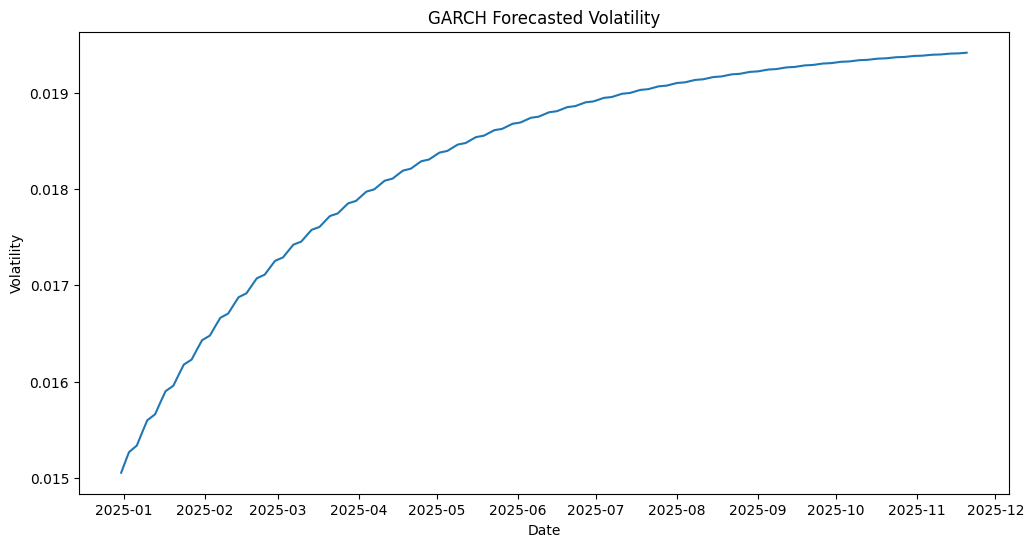

In [232]:
forecast_dates = pd.date_range(start=qqqdf['date'].iloc[-1], periods=len(forecast_vol), freq='B')

plt.figure(figsize=(12, 6))
plt.plot(forecast_dates, forecast_vol, label='Forecasted Volatility 1-12 Months Ahead')
plt.xlabel("Date")
plt.ylabel("Volatility")
plt.title("GARCH Forecasted Volatility")
plt.show()

In [233]:
#cumulative forecasted variance 
cumulative_variance = np.cumsum(garch_forecast.variance.values[-1, 19:252])

#cumulative volatility (square root of cumulative variance)
cumulative_volatility = np.sqrt(cumulative_variance)

forecast_dates = pd.date_range(start=qqqdf['date'].iloc[-1], periods=len(cumulative_variance), freq='B')

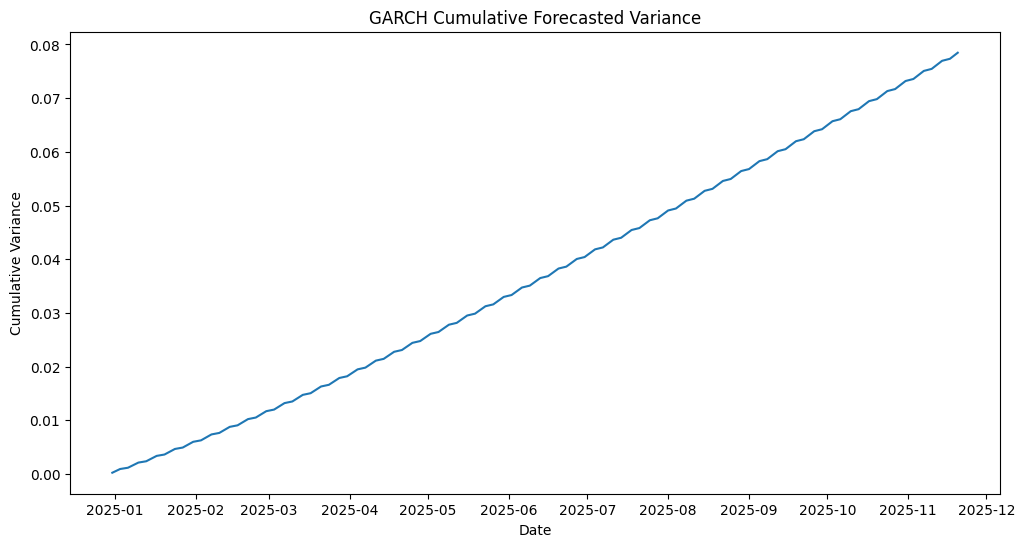

In [234]:
plt.figure(figsize=(12, 6))
plt.plot(forecast_dates, cumulative_variance, label='Cumulative Forecasted Variance')
plt.xlabel("Date")
plt.ylabel("Cumulative Variance")
plt.title("GARCH Cumulative Forecasted Variance")
plt.show()

In [235]:
#forecasted variance and volatility
forecasted_variance_1Y = cumulative_variance[-1] 
forecasted_volatility_1Y = cumulative_volatility[-1]  

print(f"Forecasted variance (next year): {forecasted_variance_1Y:.6f}")
print(f"Forecasted volatility (next year): {forecasted_volatility_1Y:.6f}")

Forecasted variance (next year): 0.078465
Forecasted volatility (next year): 0.280115


In [236]:
#standardize residuals and get kurtosis
residuals = garch_results.resid
conditional_volatility = np.sqrt(garch_results.conditional_volatility)

standardized_residuals = residuals / conditional_volatility

kurtosis = stats.kurtosis(standardized_residuals, fisher=True) 
print(f"Kurtosis (excess) of standardized residuals: {kurtosis:.4f}")

Kurtosis (excess) of standardized residuals: 156.5468


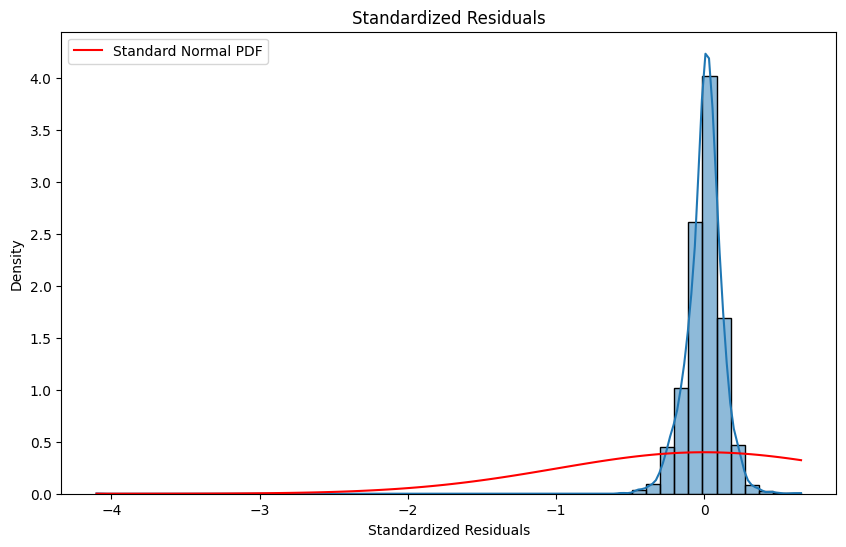

In [245]:
#plot the standardized residuals
plt.figure(figsize=(10, 6))
sns.histplot(standardized_residuals, bins=50, kde=True, stat="density")

x_vals = np.linspace(standardized_residuals.min(), standardized_residuals.max(), 100)
plt.plot(x_vals, stats.norm.pdf(x_vals, 0, 1), color='red', label="Standard Normal PDF")

plt.xlabel("Standardized Residuals")
plt.ylabel("Density")
plt.title("Standardized Residuals")
plt.legend()
plt.show()

In [227]:
#fit GARCH(1,1) with t-distributed error
garch_t_model = arch_model(qqqdf['log_ret'], vol='Garch', p=1, q=1, mean='Zero', dist='t')

garch_t_results = garch_t_model.fit(disp='off')

print(garch_t_results.summary())

                          Zero Mean - GARCH Model Results                           
Dep. Variable:                      log_ret   R-squared:                       0.000
Mean Model:                       Zero Mean   Adj. R-squared:                  0.000
Vol Model:                            GARCH   Log-Likelihood:                18314.4
Distribution:      Standardized Student's t   AIC:                          -36620.9
Method:                  Maximum Likelihood   BIC:                          -36593.9
                                              No. Observations:                 6286
Date:                      Fri, Feb 07 2025   Df Residuals:                     6286
Time:                              20:55:07   Df Model:                            0
                              Volatility Model                              
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
omeg

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/arch/univariate/base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.000371. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


In [225]:
#get df for t-dist
estimated_dof = garch_t_results.params['nu']
print(f"Estimated Degrees of Freedom for t-Distribution: {estimated_dof:.4f}")

Estimated Degrees of Freedom for t-Distribution: 4.2467


Q1 (f) The estimate for df is 4.24, which is in line with the view that the tails of this distribution are quite large, indicating high volatility